In [3]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_curve, auc
from plotnine import ggplot, geom_line, aes, labs, theme_minimal
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import recall_score, precision_score
from sklearn.metrics import cohen_kappa_score

In [109]:
heart_attack = pd.read_csv("https://www.dropbox.com/s/aohbr6yb9ifmc8w/heart_attack.csv?dl=1")
heart_attack

,age,sex,cp,trtbps,chol,restecg,thalach,output
0,63,1,3,145,233,0,150,1
1,37,1,2,130,250,1,187,1
2,56,1,1,120,236,1,178,1
3,57,0,0,120,354,1,163,1
4,57,1,0,140,192,1,148,1
...,...,...,...,...,...,...,...,...
268,59,1,0,164,176,0,90,0
269,57,0,0,140,241,1,123,0
270,45,1,3,110,264,1,132,0
271,68,1,0,144,193,1,141,0


In [110]:
print("Missing values in dataset:\n", heart_attack.isnull().sum())

print("\nData types:\n", heart_attack.dtypes)

X = heart_attack.drop('output', axis=1)
y = heart_attack['output']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state =42)

Missing values in dataset:
 age        0
sex        0
cp         0
trtbps     0
chol       0
restecg    0
thalach    0
output     0
dtype: int64

Data types:
 age        int64
sex        int64
cp         int64
trtbps     int64
chol       int64
restecg    int64
thalach    int64
output     int64
dtype: object


Part One: Fitting Models
This section asks you to create a final best model for each of the model types studied this week. For each, you should:

Find the best model based on ROC AUC for predicting the target variable.

Report the (cross-validated!) ROC AUC metric.

Fit the final model.

Output a confusion matrix; that is, the counts of how many observations fell into each predicted class for each true class.

(Where applicable) Interpret the coefficients and/or estimates produced by the model fit.

You should certainly try multiple model pipelines to find the best model. You do not need to include the output for every attempted model, but you should describe all of the models explored. You should include any hyperparameter tuning steps in your writeup as well.

Q1: KNN

In [111]:
knn_param_grid = {"n_neighbors" : range(1, 20)}

knn_grid = GridSearchCV(KNeighborsClassifier(), knn_param_grid, cv = 5, scoring = "roc_auc")

knn_grid.fit(X_train, y_train)

best_knn = knn_grid.best_estimator_

y_pred_knn = best_knn.predict(X_test)

roc_auc_knn = roc_auc_score(y_test, y_pred_knn)

conf_matrix_knn = confusion_matrix(y_test, y_pred_knn)

Q2: Logistic Regression

In [112]:
logreg_cv = GridSearchCV(LogisticRegression(max_iter = 1000),
                         {"C" : [0.01, 0.1, 1, 10, 100]},
                         cv = 5,
                         scoring = "roc_auc")

logreg_cv.fit(X_train, y_train)

best_logreg = logreg_cv.best_estimator_

y_pred_logreg = best_logreg.predict(X_test)

roc_auc_logreg = roc_auc_score(y_test, y_pred_logreg)

conf_matrix_logreg = confusion_matrix(y_test, y_pred_logreg)

Q3: Decision Tree

In [113]:
dtree_cv = GridSearchCV(DecisionTreeClassifier(),
                        {"max_depth" : range(1, 10)},
                        cv = 5,
                        scoring = "roc_auc")

dtree_cv.fit(X_train, y_train)

best_dtree = dtree_cv.best_estimator_

y_pred_dtree = best_dtree.predict(X_test)

roc_auc_dtree = roc_auc_score(y_test, y_pred_dtree)

conf_matrix_dtree = confusion_matrix(y_test, y_pred_dtree)

Q4: Interpretation

Which predictors were most important to predicting heart attack risk?

In [114]:
knn_importance = knn_grid.best_estimator_

print(" KNN Coefficients:\n", knn_importance)

 KNN Coefficients:
 KNeighborsClassifier(n_neighbors=19)


In [115]:
logreg_coefficients = best_logreg.coef_

print("Logistic Regression Coefficients:\n", logreg_coefficients)

Logistic Regression Coefficients:
 [[-0.03170367 -2.64748235  0.86594825 -0.01567944 -0.00523816  0.07750405
   0.05836355]]


In [116]:
dtree_importance = best_dtree.feature_importances_

print("Decision Tree Feature Importances:\n", dtree_importance)

Decision Tree Feature Importances:
 [0.06060173 0.1000221  0.56811591 0.06091251 0.         0.
 0.21034775]


#Q5: ROC Curve

Plot the ROC Curve for your three models above.

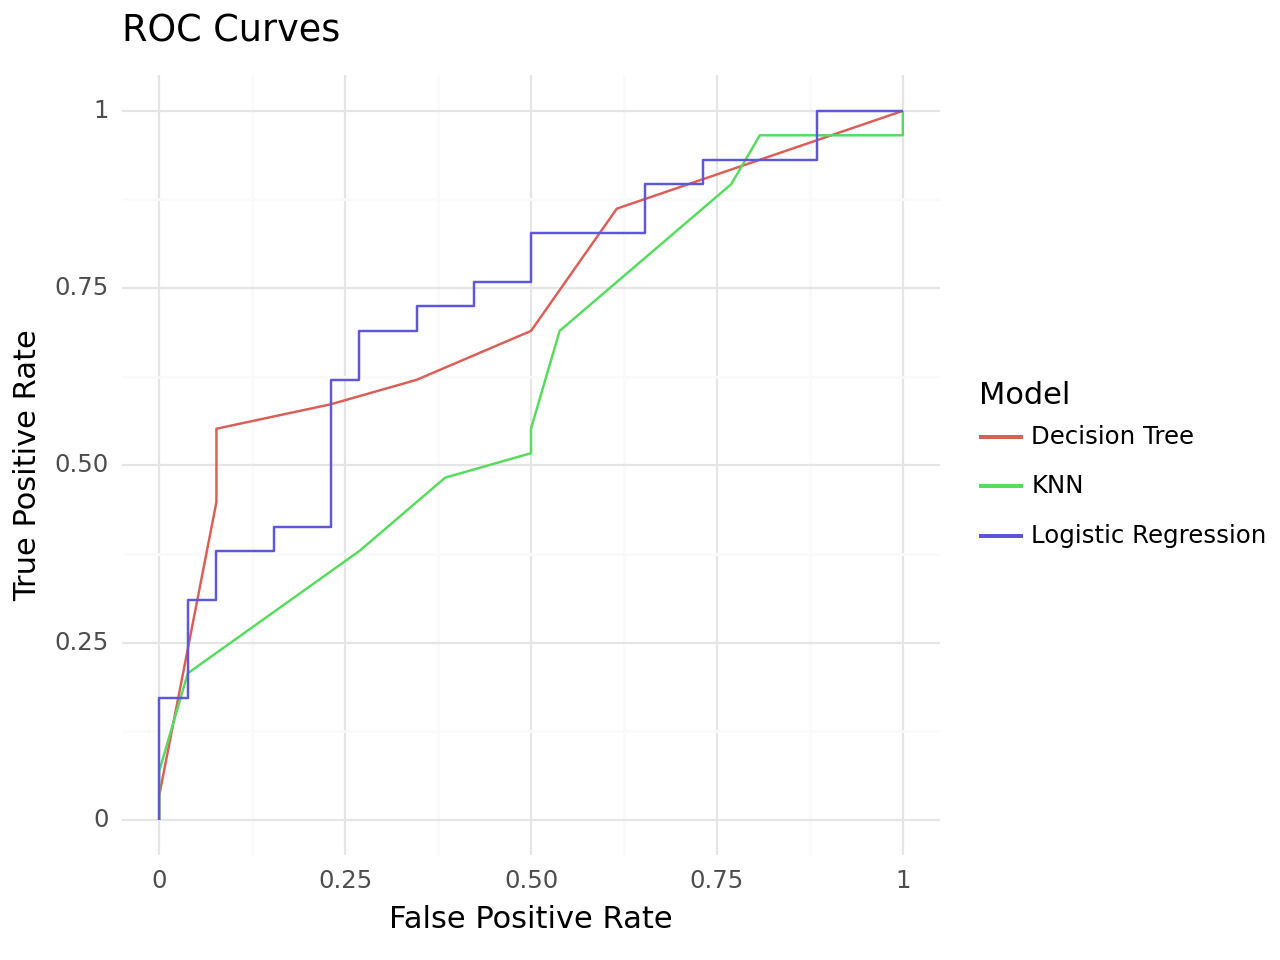

In [117]:
fpr_knn, tpr_knn, _ = roc_curve(y_test, knn_grid.predict_proba(X_test)[:, 1])
roc_auc_knn = auc(fpr_knn, tpr_knn)

fpr_logreg, tpr_logreg, _ = roc_curve(y_test, logreg_cv.predict_proba(X_test)[:, 1])
roc_auc_logreg = auc(fpr_logreg, tpr_logreg)

fpr_dtree, tpr_dtree, _ = roc_curve(y_test, dtree_cv.predict_proba(X_test)[:, 1])
roc_auc_dtree = auc(fpr_dtree, tpr_dtree)

roc_data = pd.DataFrame({
    'FPR': fpr_knn.tolist() + fpr_logreg.tolist() + fpr_dtree.tolist(),
    'TPR': tpr_knn.tolist() + tpr_logreg.tolist() + tpr_dtree.tolist(),
    'Model': ['KNN']*len(fpr_knn) + ['Logistic Regression']*len(fpr_logreg) + ['Decision Tree']*len(fpr_dtree)})

(ggplot(roc_data, aes(x='FPR', y='TPR', color='Model'))
 + geom_line()
 + labs(title="ROC Curves", x="False Positive Rate", y="True Positive Rate")
 + theme_minimal()
).draw()


Part Two: Metrics
Consider the following metrics:

True Positive Rate or Recall or Sensitivity = Of the observations that are truly Class A, how many were predicted to be Class A?

Precision or Positive Predictive Value = Of all the observations classified as Class A, how many of them were truly from Class A?

True Negative Rate or Specificity or Negative Predictive Value = Of all the observations classified as NOT Class A, how many were truly NOT Class A?



Compute each of these metrics (cross-validated) for your three models (KNN, Logistic Regression, and Decision Tree) in Part One

In [118]:
y_pred_knn_cv = cross_val_predict(best_knn, X, y, cv=5)

recall_knn = recall_score(y, y_pred_knn_cv)
precision_knn = precision_score(y, y_pred_knn_cv)
tn_knn, fp_knn, fn_knn, tp_knn = confusion_matrix(y, y_pred_knn_cv).ravel()
specificity_knn = tn_knn / (tn_knn + fp_knn)

print(f"KNN - Recall: {recall_knn}, Precision: {precision_knn}, Specificity: {specificity_knn}")

KNN - Recall: 0.678082191780822, Precision: 0.6513157894736842, Specificity: 0.5826771653543307


In [119]:
y_pred_logreg_cv = cross_val_predict(best_logreg, X, y, cv=5)

recall_logreg = recall_score(y, y_pred_logreg_cv)
precision_logreg = precision_score(y, y_pred_logreg_cv)
tn_logreg, fp_logreg, fn_logreg, tp_logreg = confusion_matrix(y, y_pred_logreg_cv).ravel()
specificity_logreg = tn_logreg / (tn_logreg + fp_logreg)

print(f"Logistic Regression - Recall: {recall_logreg}, Precision: {precision_logreg}, Specificity: {specificity_logreg}")

Logistic Regression - Recall: 0.815068493150685, Precision: 0.7828947368421053, Specificity: 0.7401574803149606


In [120]:
y_pred_dtree_cv = cross_val_predict(best_dtree, X, y, cv=5)

recall_dtree = recall_score(y, y_pred_dtree_cv)
precision_dtree = precision_score(y, y_pred_dtree_cv)
tn_dtree, fp_dtree, fn_dtree, tp_dtree = confusion_matrix(y, y_pred_dtree_cv).ravel()
specificity_dtree = tn_dtree / (tn_dtree + fp_dtree)

print(f"Decision Tree - Recall: {recall_dtree}, Precision: {precision_dtree}, Specificity: {specificity_dtree}")

Decision Tree - Recall: 0.7465753424657534, Precision: 0.7956204379562044, Specificity: 0.7795275590551181


#Part Three: Discussion
Suppose you have been hired by a hospital to create classification models for heart attack risk.

The following questions give a possible scenario for why the hospital is interested in these models. For each one, discuss:

Which metric(s) you would use for model selection and why.

True Positive Rate (Recall or Sensitivity): Crucial for scenarios where missing a high-risk patient (false negative) could be catastrophic. A high recall indicates the model is good at catching most of the positive cases.

Precision (Positive Predictive Value): Important when the cost of a false positive is high. In a hospital setting, this could mean unnecessary treatments or tests.

ROC AUC: Useful for evaluating the overall performance of a model, particularly its ability to distinguish between classes.

Specificity (True Negative Rate): Vital in situations where you want to confidently rule out patients who are not at risk.

Which of your final models (Part One Q1-3) you would recommend to the hospital, and why.

If the hospital's primary concern is accuracy and it has the computational resources to handle it, KNN might be the best choice. For a balance between interpretability and performance, especially when linear relationships are expected, Logistic Regression would be ideal.

If interpretability, especially understanding the decision-making process of the model, is crucial, and the hospital is dealing with complex, non-linear patterns in data, a Decision Tree would be recommended.

 It's essential to consider that each model has its strengths and weaknesses, and the choice should align with the hospital's specific needs and constraints. Additionally, the performance metrics (like ROC AUC, recall, precision) of each model on the cross-validation should also be a deciding factor, as they provide an objective measure of each model's ability to predict heart attack risk accurately.

What score you should expect for your chosen metric(s) using your chosen model to predict future observations.

The expected score for your chosen metrics using the selected model to predict future observations can be estimated based on the cross-validated metrics obtained during model training. However, it's important to note that these estimates are just that – estimates. The actual performance on future data may vary due to several factors, such as changes in the characteristics of the patient population or differences between the training data and new data.

#Q1
The hospital faces severe lawsuits if they deem a patient to be low risk, and that patient later experiences a heart attack.

Key Metric: Recall (True Positive Rate).

Reason: High recall minimizes the chance of missing a high-risk patient (false negatives).

Expected Score: Look for a model that has demonstrated the highest recall in your cross-validation. However, it's important to remember that a very high recall might come at the expense of precision, leading to more false positives.

Recommended Model: Typically, a Decision Tree or Logistic Regression, depending on which showed higher recall in your tests.

#Q2
The hospital is overfull, and wants to only use bed space for patients most in n#eed of monitoring due to heart attack risk.

Key Metric: Precision (Positive Predictive Value).

Reason: High precision ensures that the majority of patients classified as high-risk truly require the bed space.

Expected Score: Choose the model with the highest precision from your tests. However, balancing precision with recall is essential to avoid missing too many true high-risk cases.

Recommended Model: Logistic Regression often offers a good balance, but it depends on your specific model results.

#Q3
The hospital is studying root causes of heart attacks, and would like to understand which biological measures are associated with heart attack risk.



Key Metric: Feature Importance or Coefficients.

Reason: Understanding which features are most predictive can provide insights into the root causes of heart attacks.

Expected Insights: Decision Trees and Logistic Regression provide interpretable models that can highlight the importance of different features.

Recommended Model: Decision Tree for non-linear relationships and Logistic Regression for linear relationships.

#Q4
The hospital is training a new batch of doctors, and they would like to compare the diagnoses of these doctors to the predictions given by the algorithm to measure the ability of new doctors to diagnose patients.

Key Metric: Overall Accuracy, ROC AUC.

Reason: You want a balanced model that generalizes well for comparison purposes.

Expected Score: A model with a high ROC AUC would be suitable as it measures the ability to distinguish between classes. Accuracy can also be a straightforward metric for comparison.

Recommended Model: Logistic Regression for its interpretability and balance, or KNN if it has demonstrated superior performance in distinguishing between classes.

Part Four: Validation
Before sharing the dataset with you, I set aside a random 10% of the observations to serve as a final validation set.

In [121]:
heart_attack_val = pd.read_csv("https://www.dropbox.com/s/jkwqdiyx6o6oad0/heart_attack_validation.csv?dl=1")
heart_attack_val

,age,sex,cp,trtbps,chol,restecg,thalach,output
0,41,0,1,130,204,0,172,1
1,64,1,3,110,211,0,144,1
2,59,1,0,135,234,1,161,1
3,42,1,0,140,226,1,178,1
4,40,1,3,140,199,1,178,1
5,54,1,2,125,273,0,152,1
6,52,1,1,134,201,1,158,1
7,71,0,2,110,265,0,130,1
8,55,0,1,135,250,0,161,1
9,58,1,2,105,240,0,154,1


In [122]:
print("Missing values in dataset:\n", heart_attack_val.isnull().sum())

print("\nData types:\n", heart_attack_val.dtypes)

X_val = heart_attack_val.drop("output", axis=1)

y_val = heart_attack_val["output"]

Missing values in dataset:
 age        0
sex        0
cp         0
trtbps     0
chol       0
restecg    0
thalach    0
output     0
dtype: int64

Data types:
 age        int64
sex        int64
cp         int64
trtbps     int64
chol       int64
restecg    int64
thalach    int64
output     int64
dtype: object


Use each of your final models in Part One Q1-3, predict the target variable in the validation dataset.

In [129]:
y_pred_knn_val = best_knn.predict(X_val)

y_pred_logreg_val = best_logreg.predict(X_val)

y_pred_dtree_val = best_dtree.predict(X_val)

Compare these values to the cross-validated estimates you reported in Part One and Part Two. Did our measure of model success turn out to be approximately correct for the validation data?

In [124]:
roc_auc_knn_val = roc_auc_score(y_val, y_pred_knn_val)
precision_knn_val = precision_score(y_val, y_pred_knn_val)
recall_knn_val = recall_score(y_val, y_pred_knn_val)
conf_matrix_knn_val = confusion_matrix(y_val, y_pred_knn_val)

roc_auc_logreg_val = roc_auc_score(y_val, y_pred_logreg_val)
precision_logreg_val = precision_score(y_val, y_pred_logreg_val)
recall_logreg_val = recall_score(y_val, y_pred_logreg_val)
conf_matrix_logreg_val = confusion_matrix(y_val, y_pred_logreg_val)

roc_auc_dtree_val = roc_auc_score(y_val, y_pred_dtree_val)
precision_dtree_val = precision_score(y_val, y_pred_dtree_val)
recall_dtree_val = recall_score(y_val, y_pred_dtree_val)
conf_matrix_dtree_val = confusion_matrix(y_val, y_pred_dtree_val)


For each, output a confusion matrix, and report the ROC AUC, the precision, and the recall.

In [125]:
print("KNN Model - ROC AUC:", roc_auc_knn_val, "Precision:", precision_knn_val, "Recall:", recall_knn_val, "Confusion Matrix:\n", conf_matrix_knn_val)

print("Logistic Regression Model - ROC AUC:", roc_auc_logreg_val, "Precision:", precision_logreg_val, "Recall:", recall_logreg_val, "Confusion Matrix:\n", conf_matrix_logreg_val)

print("Decision Tree Model - ROC AUC:", roc_auc_dtree_val, "Precision:", precision_dtree_val, "Recall:", recall_dtree_val, "Confusion Matrix:\n", conf_matrix_dtree_val)


KNN Model - ROC AUC: 0.6411483253588517 Precision: 0.7368421052631579 Recall: 0.7368421052631579 Confusion Matrix:
 [[ 6  5]
 [ 5 14]]
Logistic Regression Model - ROC AUC: 0.777511961722488 Precision: 0.875 Recall: 0.7368421052631579 Confusion Matrix:
 [[ 9  2]
 [ 5 14]]
Decision Tree Model - ROC AUC: 0.7057416267942583 Precision: 0.8125 Recall: 0.6842105263157895 Confusion Matrix:
 [[ 8  3]
 [ 6 13]]


Part Five: Cohen’s Kappa
Another common metric used in classification is Cohen’s Kappa.

Use online resources to research this measurement. Calculate it for the models from Part One, Q1-3, and discuss reasons or scenarios that would make us prefer to use this metric as our measure of model success. Do your conclusions from above change if you judge your models using Cohen’s Kappa instead? Does this make sense?

In [126]:
y_pred_knn = best_knn.predict(X_test)

kappa_knn = cohen_kappa_score(y_test, y_pred_knn)

print(f"KNN Model - Cohen's Kappa: {kappa_knn}")

KNN Model - Cohen's Kappa: 0.017207147584381244


In [127]:
y_pred_logreg = best_logreg.predict(X_test)

kappa_logreg = cohen_kappa_score(y_test, y_pred_logreg)

print(f"Logistic Regression Model - Cohen's Kappa: {kappa_logreg}")

Logistic Regression Model - Cohen's Kappa: 0.2819843342036553


In [128]:
y_pred_dtree = best_dtree.predict(X_test)

kappa_dtree = cohen_kappa_score(y_test, y_pred_dtree)

print(f"Decision Tree Model - Cohen's Kappa: {kappa_dtree}")

Decision Tree Model - Cohen's Kappa: 0.27344782034346105


When assessing classification models, Cohen's Kappa is a useful indicator, especially when the distribution of the classes is unbalanced. By correcting for the imbalance and taking the risk of chance agreement into consideration, it provides a more sophisticated evaluation of a model's performance. This gives it additional value when comparing models that could have comparable accuracy results as it offers a more thorough understanding of the consistency and dependability of the categorization. Cohen's Kappa is a robust indicator of model performance; a higher value denotes a more trustworthy categorization by the model. It's crucial to compare the Cohen's Kappa values of each model when evaluating these scores since a higher number denotes a more reliable and agreeable model.

Furthermore, if the Cohen's Kappa values differ noticeably from other measures like ROC AUC, precision, or recall, this may indicate that the class distribution has a greater impact on the models' accuracy than their capacity to classify examples properly. Conducting these tests within a Python environment yields a thorough analysis, facilitating better decision-making for model choice and functionality.
